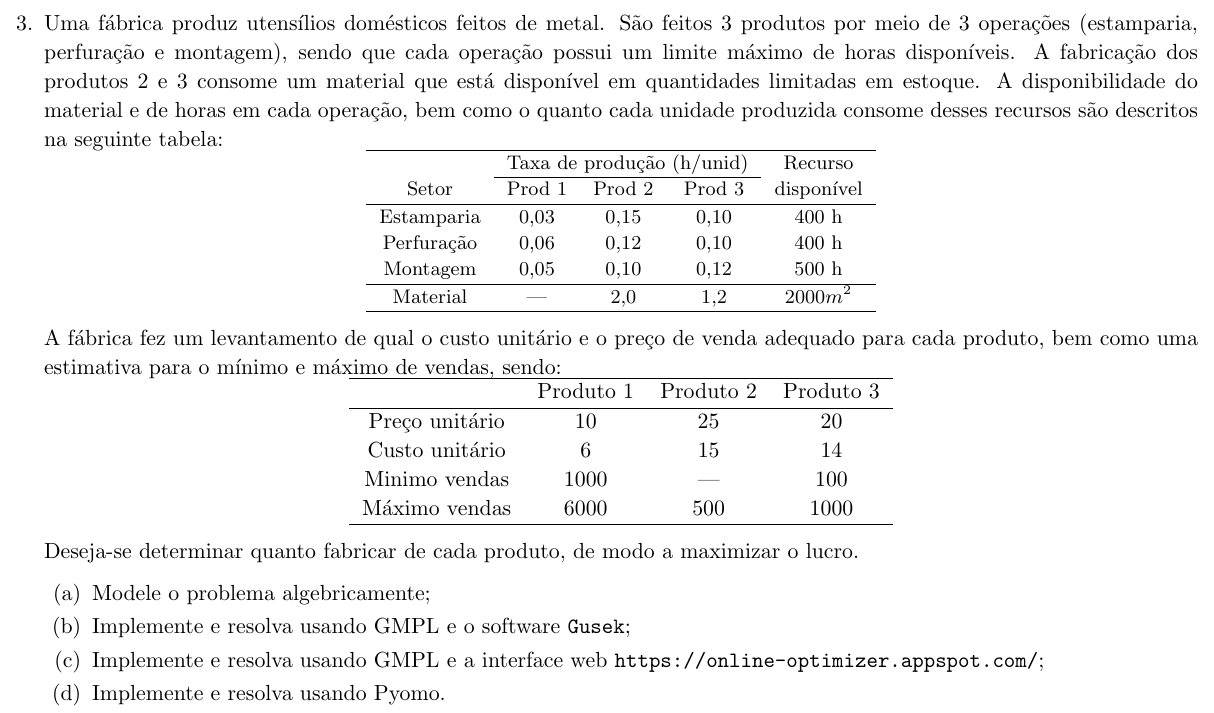

In [19]:
from IPython.display import Image
Image(filename='images/3.png')

In [12]:
# Dados
# Conjuntos
Produtos = [1, 2, 3]
Recursos = ['Estamparia', 'Perfuração', 'Montagem', 'Material']
# Parâmetros
receita = {1: 10, 2: 25, 3: 20}
custo = {1: 6, 2: 15, 3:14}
min_vendas = {1: 1000, 2: 0, 3: 100}
max_vendas = {1: 6000, 2: 500, 3: 1000}
recursos = {('Estamparia', 1): 0.03, ('Estamparia', 2): 0.15, ('Estamparia', 3): 0.1,
            ('Perfuração', 1): 0.06, ('Perfuração', 2): 0.12, ('Perfuração', 3): 0.1,
            ('Montagem', 1): 0.05, ('Montagem', 2): 0.1, ('Montagem', 3): 0.12,
            ('Material', 1): 0, ('Material', 2): 2, ('Material', 3): 1.2}
estoque = {'Estamparia': 400, 'Perfuração': 400, 'Montagem': 500, 'Material': 2000}

In [13]:
# Módulos
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [14]:
# Definição do modelo
model = ConcreteModel()

# Conjuntos
model.P = Set(initialize = Produtos)  # produtos
model.R = Set(initialize = Recursos)  # recursos

# Parâmetros
model.r = Param(model.P, initialize = receita, within = NonNegativeReals)  # receita
model.c = Param(model.P, initialize = custo, within = NonNegativeReals)  # custo
model.L = Param(model.P, initialize = min_vendas, within = NonNegativeReals)  # min_vendas
model.U = Param(model.P, initialize = max_vendas, within = NonNegativeReals)  # max_vendas
model.a = Param(model.R * model.P, initialize = recursos, within = NonNegativeReals)  # recursos utilizados
model.b = Param(model.R, initialize = estoque, within = NonNegativeReals)  # estoque de recursos disponíveis

# Variáveis de decisão
    # Quantidade de cada produto a ser fabricada
model.x = Var(model.P, within = NonNegativeIntegers)

# Função objetivo (Maximizar lucro)
model.objective = Objective(sense = maximize, 
                            expr = sum((model.r[i] - model.c[i]) * model.x[i] for i in model.P))

# Restrições
    # Estoque
model.r_estoque = ConstraintList()
for j in model.R:
    model.r_estoque.add(expr = sum(model.a[j,i] * model.x[i] for i in model.P) <= model.b[j])
    # Demanda
model.r_demanda = ConstraintList()
for i in model.P:
    model.r_demanda.add(expr = model.x[i] <= model.U[i])  # Limite superior
    model.r_demanda.add(expr = model.x[i] >= model.L[i])  # Limite inferior

# model.pprint()

In [15]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee = False)

In [18]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    for i in model.P:
        print('Quantidade a ser produzida do produto {}: {}'.format(i, value(model.x[i])))
    print()
    print('O lucro máximo obtido é R${:.2f}.'.format(model.objective.expr()))
else:
    print(resultado.solver.termination_condition)

Quantidade a ser produzida do produto 1: 5500.0
Quantidade a ser produzida do produto 2: 500.0
Quantidade a ser produzida do produto 3: 100.0

O lucro máximo obtido é R$27600.00.
